# Particle simulation vs Langevin model

In [1]:
using ProgressMeter
using Revise
using JLD2

In [2]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

## Growing population

### Parameters

In [3]:
using Plots
# plotly()
gr()
# plotlyjs()
# pyplot()

Plots.GRBackend()

In [4]:
using LaTeXStrings

In [5]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
    arenaParams["E"] = arenaParams["speed"]^2/2
end

extendParams! (generic function with 1 method)

In [6]:
arenaParams = 
    Dict(
        "n0"=>100,
        "evolveTime"=>4500,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.02,
        "timeStep"=> 0.1
    )

growthParams =
    Dict(
        "ρ"=> 0.002,
        "k"=> 1000,
        "randGrowth"=> false,
        "waitTime"=> 500
    )

extendParams!(arenaParams)

display(arenaParams)
display(growthParams)

function fillDensity(arenaParams, growthParams)  
    xperiod = abs(arenaParams["bounds"][1][2] - arenaParams["bounds"][1][1])
    yperiod = abs(arenaParams["bounds"][2][2] - arenaParams["bounds"][2][1])
    n0 = arenaParams["n0"]
    nT = growthParams["k"]
    r = arenaParams["radius"]
    V = xperiod*yperiod
    fillDens0 = n0*π*r^2 / V
    fillDensT = nT*π*r^2 / V
    return fillDens0, fillDensT
end

volumeDens(n, r, V) = n*π*r^2/V

timeSteps = arenaParams["timeStep"]:arenaParams["timeStep"]:arenaParams["evolveTime"]

println("t0 density: ", fillDensity(arenaParams, growthParams)[1])
println("t0 density: ", fillDensity(arenaParams, growthParams)[2])

Dict{String,Any} with 9 entries:
  "volume"     => 100.0
  "evolveTime" => 4500
  "speed"      => 0.02
  "radius"     => 0.08
  "timeStep"   => 0.1
  "E"          => 0.0002
  "bounds"     => ((0.0, 10.0), (0.0, 10.0))
  "bperiod"    => [10.0, 10.0]
  "n0"         => 100

Dict{String,Real} with 4 entries:
  "waitTime"   => 500
  "k"          => 1000
  "ρ"          => 0.005
  "randGrowth" => false

t0 density: 0.02010619298297468
t0 density: 0.20106192982974677


### Logistic Growth

The number of cells in the system increases according to the logistic growth function:
\begin{equation}
n(t) = \frac{k}{ 1 + \frac{k-n_0}{n_0}e^{-\rho t}}
\end{equation}


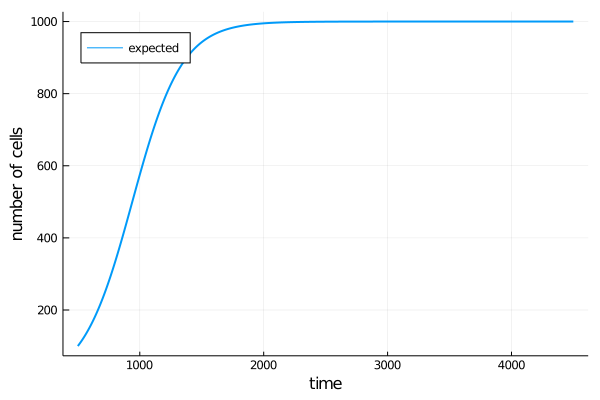

In [7]:
f1 = plot(growthParams["waitTime"]:(arenaParams["evolveTime"]-1), 
        Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]), 
        label="expected", linewidth=2, legend=:topleft)
xlabel!("time")
ylabel!("number of cells")
display(f1)

Mean Free Path and Friction

In [8]:
# nCells_t = append!(arenaParams["n0"]*ones( Float64, 0:(growthParams["waitTime"]) ), Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
#             growthParams["ρ"], growthParams["k"], arenaParams["n0"]));
nCells_t = Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]);

mfpTheory_t = (x -> Theorist.meanFreePath(x, 4*arenaParams["radius"])).(nCells_t);
frictionTheory_t = ( l -> Theorist.friction(l, arenaParams["E"]) ).(mfpTheory_t);

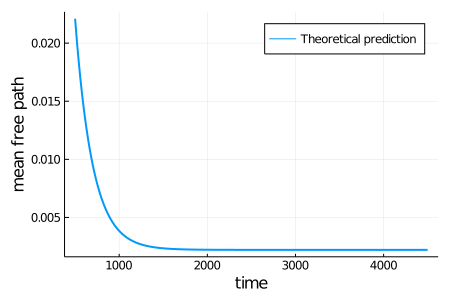

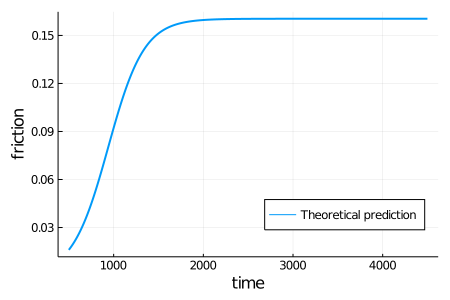

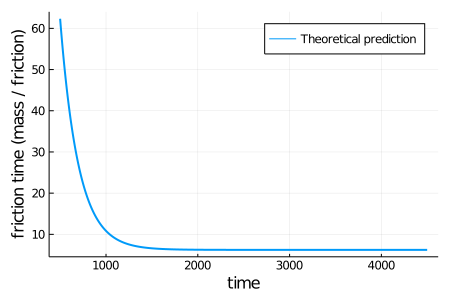

In [9]:
f2 = plot(growthParams["waitTime"]:arenaParams["evolveTime"]-1, mfpTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:topright,
        size=(450,300))
xlabel!("time")
ylabel!("mean free path")
display(f2)

# savefig(f2, "../Figures/rho"*string(growthParams["ρ"])*"mfp_time.pdf")

f3 = plot(growthParams["waitTime"]:arenaParams["evolveTime"]-1, 
            arenaParams["speed"]*frictionTheory_t,
        label="Theoretical prediction",
        linewidth=2,
        legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction")
display(f3)

# savefig(f3, "../Figures/rho"*string(growthParams["ρ"])*"friction_time.pdf")

f4 = plot(growthParams["waitTime"]:arenaParams["evolveTime"]-1,
            1 ./ (arenaParams["speed"]*frictionTheory_t),
        label="Theoretical prediction",
        linewidth=2,
#         legend=:bottomright,
        size=(450,300))
xlabel!("time")
ylabel!("friction time (mass / friction)")
display(f4)

# savefig(f4, "../Figures/rho"*string(growthParams["ρ"])*"frictionTime_time.pdf")

Run Langevin simulations:

In [10]:
@time langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams, growthParams);

Energy: 0.0002
193.010727 seconds (5.35 G allocations: 90.652 GiB, 15.20% gc time)


Run a particle simulation:

In [11]:
# @time arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID, times_t = 
#         BParts.randArenaEvolve(
#             arenaParams["n0"], 
#             arenaParams["evolveTime"],
#             arenaParams["timeStep"],
#             arenaParams,
#             growthParams);

In [12]:
# f1 = plot(growthParams["waitTime"]:(arenaParams["evolveTime"]-1), 
#         volumeDens.(
#             Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
#             growthParams["ρ"], growthParams["k"], arenaParams["n0"]),
#             arenaParams["radius"],
#             arenaParams["volume"]
#         ),
#         label="growth function",
#         linewidth=2,
#         size=(450,300),
#         legend=:topleft)
# plot!(times_t, 
#     volumeDens.(
#         BParts.nCellsTime(cells_T_ID)[1:end],     
#         arenaParams["radius"],
#         arenaParams["volume"]
#     ),
#     label="particle simulation",
#     linewidth=2,
#     linestyle=:dash)
# xlabel!("time")
# ylabel!("occupied surface density")
# display(f1)

# # savefig(f1, "../Figures/surfaceDensity_time_rho"*string(growthParams["ρ"])*".pdf")

Ensemble of particle simulations:

In [13]:
nSims = 50

pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], 
                    arenaParams["timeStep"], arenaParams, growthParams; 
                    progress=false, verbose=true);
            pos_Sim[i] = posSim_t_dim_id
#             println("sim: ", i)
        catch e
           continue 
        end
        succes = true
    end
end

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.17288139595330715 found in time step0.1
anomalous collision time 16.798987616522503 found in time step0.1
anomalous collision time 4.259440542813917 found in time step0.1
anomalous collision time 3.3589507238219904 found in time step0.1
anomalous collision time 5.819837479101855 found in time step0.1
anomalous collision time 24.906259972156203 found in time step0.1
anomalous collision time 14.060872494998428 found in time step0.1
anomalous collision time 47.98657179432524 found in time step0.1
anomalous collision time 24.90625997215619 found in time step0.1
anomalous collision time 20.58067225025438 found in time step0.1
anomalous collision time 67.06958484515924 found in time step0.1
anomalous collision time 13.072910986292062 found in time step0.1
anomalous collision time 5.10135297343521 found in time step0.1
anomalous collision time 82.1

Progress:   2%|▉                                        |  ETA: 4:41:42

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:   4%|█▋                                       |  ETA: 4:27:30

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 2.0210688988055305 found in time step0.1
anomalous collision time 12.273972500449583 found in time step0.1
anomalous collision time 14.800931683881148 found in time step0.1
anomalous collision time 14.492301395159252 found in time step0.1
anomalous collision time 10.6536139120693 found in time step0.1
anomalous collision time 18.931950675809233 found in time step0.1
anomalous collision time 8.519479510048384 found in time step0.1
anomalous collision time 25.28553819973359 found in time step0.1
anomalous collision time 9.79140345168026 found in time step0.1
anomalous collision time 8.773966315245678 found in time step0.1
anomalous collision time 5.414307286867823 found in time step0.1
anomalous collision time 0.457670868849964 found in time step0.1
anomalous collision time 5.224122938074016 found in time step0.1
anomalous collision time 8.18980

Progress:   6%|██▌                                      |  ETA: 4:48:10

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.1337664035322065 found in time step0.1
anomalous collision time 7.9828247480731145 found in time step0.1
anomalous collision time 8.126252225594333 found in time step0.1
anomalous collision time 3.552272351668789 found in time step0.1
anomalous collision time 8.010440240460207 found in time step0.1
anomalous collision time 2.079311076905383 found in time step0.1
anomalous collision time 8.010440240460229 found in time step0.1
anomalous collision time 13.049818404590981 found in time step0.1
anomalous collision time 4.872375514215003 found in time step0.1
anomalous collision time 15.007208318678101 found in time step0.1
anomalous collision time 2.4964432186127534 found in time step0.1
anomalous collision time 8.010440240460273 found in time step0.1
anomalous collision time 6.2513906425262284 found in time step0.1
anomalous collision time 15.0

Progress:   8%|███▎                                     |  ETA: 4:50:26

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.12406573671403645 found in time step0.1
anomalous collision time 2.251916945290328 found in time step0.1
anomalous collision time 34.946368797527334 found in time step0.1
anomalous collision time 2.877651086730542 found in time step0.1
anomalous collision time 45.217510742006496 found in time step0.1
anomalous collision time 3.8450707518119907 found in time step0.1
anomalous collision time 0.4566120456042918 found in time step0.1
anomalous collision time 45.217510742006475 found in time step0.1
anomalous collision time 1.5134457772285397 found in time step0.1
anomalous collision time 45.217510742006475 found in time step0.1
anomalous collision time 1.9937837888657455 found in time step0.1
anomalous collision time 5.8803637726305675 found in time step0.1
anomalous collision time 1.6924771741248354 found in time step0.1
anomalous collision tim

Progress:  10%|████▏                                    |  ETA: 5:00:39

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 3.5424917402782294 found in time step0.1
anomalous collision time 3.02360278284429 found in time step0.1
anomalous collision time 3.698334289077237 found in time step0.1
anomalous collision time 1.4865694855827867 found in time step0.1
anomalous collision time 3.6983342890772692 found in time step0.1
anomalous collision time 10.436484791116955 found in time step0.1
anomalous collision time 3.6983342890772706 found in time step0.1
anomalous collision time 11.714052964689568 found in time step0.1
anomalous collision time 6.718095860211459 found in time step0.1
anomalous collision time 15.015301184293577 found in time step0.1
anomalous collision time 5.903153104004978 found in time step0.1
anomalous collision time 5.223115462266669 found in time step0.1
anomalous collision time 4.200603290666342 found in time step0.1
anomalous collision time 15.0

Progress:  12%|████▉                                    |  ETA: 5:01:10

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  14%|█████▊                                   |  ETA: 5:21:36

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.1682946664382111 found in time step0.1
anomalous collision time 7.3009360801816054 found in time step0.1
anomalous collision time 2.9844359615166876 found in time step0.1
anomalous collision time 4.489316938265796 found in time step0.1
anomalous collision time 9.212826297777807 found in time step0.1
anomalous collision time 3.7194517931112023 found in time step0.1
anomalous collision time 0.4548640676096727 found in time step0.1
anomalous collision time 5.516496916814213 found in time step0.1
anomalous collision time 8.084676650306244 found in time step0.1
anomalous collision time 4.261629602880264 found in time step0.1
anomalous collision time 17.65860686396681 found in time step0.1
anomalous collision time 7.765888244275409 found in time step0.1
anomalous collision time 7.0614528250915 found in time step0.1
anomalous collision time 17.6586

Progress:  16%|██████▌                                  |  ETA: 5:10:12

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  18%|███████▍                                 |  ETA: 4:53:53

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.1330973656303873 found in time step0.1
anomalous collision time 0.23308808624777302 found in time step0.1
anomalous collision time 13.637513100278879 found in time step0.1
anomalous collision time 4.208142902283477 found in time step0.1
anomalous collision time 4.4159847626557776 found in time step0.1
anomalous collision time 13.977070931803944 found in time step0.1
anomalous collision time 1.3107393845861497 found in time step0.1
anomalous collision time 0.8559843735786995 found in time step0.1
anomalous collision time 14.479505803198215 found in time step0.1
anomalous collision time 2.78248156644281 found in time step0.1
anomalous collision time 2.7824815664428053 found in time step0.1
anomalous collision time 14.479505803198224 found in time step0.1
anomalous collision time 3.953514551879604 found in time step0.1
anomalous collision time 

Progress:  20%|████████▎                                |  ETA: 4:39:41

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.2331512320938143 found in time step0.1
anomalous collision time 15.366620605597921 found in time step0.1
anomalous collision time 1.129077281622835 found in time step0.1
anomalous collision time 12.587711345037157 found in time step0.1
anomalous collision time 15.555401146024321 found in time step0.1
anomalous collision time 0.15597688321468406 found in time step0.1
anomalous collision time 5.4213743060647825 found in time step0.1
anomalous collision time 36.334063250533276 found in time step0.1
anomalous collision time 3.9784314084174732 found in time step0.1
anomalous collision time 36.33406325053347 found in time step0.1
anomalous collision time 5.4187418612817755 found in time step0.1
anomalous collision time 36.33406325053346 found in time step0.1
anomalous collision time 4.58177052708546 found in time step0.1
anomalous collision time 6

Progress:  22%|█████████                                |  ETA: 4:27:09

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  24%|█████████▉                               |  ETA: 4:15:52

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  26%|██████████▋                              |  ETA: 4:05:18

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  28%|███████████▌                             |  ETA: 3:55:19

Building arena...
0 overlaps found.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  30%|████████████▎                            |  ETA: 3:46:03

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.40753969834330794 found in time step0.1
anomalous collision time 6.415033376921775 found in time step0.1
anomalous collision time 9.748904846918364 found in time step0.1
anomalous collision time 6.6918827268418815 found in time step0.1
anomalous collision time 1.775949915162281 found in time step0.1
anomalous collision time 5.400320322414673 found in time step0.1
anomalous collision time 10.391248497722474 found in time step0.1
anomalous collision time 6.69188272684189 found in time step0.1
anomalous collision time 4.1527380038225115 found in time step0.1
anomalous collision time 4.57554375061843 found in time step0.1
anomalous collision time 2.0452229652070346 found in time step0.1
anomalous collision time 5.467579564619308 found in time step0.1
anomalous collision time 23.582098679396854 found in time step0.1
anomalous collision time 9.182

Progress:  32%|█████████████▏                           |  ETA: 3:37:23

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 34.463923757959186 found in time step0.1
anomalous collision time 1.8284705228755915 found in time step0.1
anomalous collision time 3.258165599839213 found in time step0.1
anomalous collision time 5.483856487264069 found in time step0.1
anomalous collision time 4.185044539599216 found in time step0.1
anomalous collision time 14.97382951974199 found in time step0.1
anomalous collision time 0.9792660271566335 found in time step0.1
anomalous collision time 14.97382951974198 found in time step0.1
anomalous collision time 14.973829519741983 found in time step0.1
anomalous collision time 14.325593113579673 found in time step0.1
anomalous collision time 16.75508998192762 found in time step0.1


Progress:  34%|██████████████                           |  ETA: 3:29:05

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.10376275376710858 found in time step0.1
anomalous collision time 2.0658287531730952 found in time step0.1
anomalous collision time 5.01957198354713 found in time step0.1
anomalous collision time 5.061589020084615 found in time step0.1
anomalous collision time 0.12692936771852595 found in time step0.1
anomalous collision time 266.0591022014257 found in time step0.1
anomalous collision time 266.0591022014256 found in time step0.1
anomalous collision time 2.443906107033279 found in time step0.1
anomalous collision time 2.105266320512435 found in time step0.1
anomalous collision time 17.513413560112983 found in time step0.1
anomalous collision time 4.399996672013934 found in time step0.1
anomalous collision time 17.513413560113204 found in time step0.1
anomalous collision time 30.384435477375945 found in time step0.1
anomalous collision time 4.7

Progress:  36%|██████████████▊                          |  ETA: 3:21:02

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  38%|███████████████▋                         |  ETA: 3:13:13

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 1.4059685668473636 found in time step0.1
anomalous collision time 1.4527104603081256 found in time step0.1
anomalous collision time 10.819660728827982 found in time step0.1
anomalous collision time 6.175254392894212 found in time step0.1
anomalous collision time 10.903704586263418 found in time step0.1
anomalous collision time 3.048438002081033 found in time step0.1
anomalous collision time 2.919414997065439 found in time step0.1
anomalous collision time 8.736709410329665 found in time step0.1
anomalous collision time 1.281808614308223 found in time step0.1
anomalous collision time 3.006982651895278 found in time step0.1
anomalous collision time 13.982616280368736 found in time step0.1
anomalous collision time 5.326874232592295 found in time step0.1
anomalous collision time 6.193307854206956 found in time step0.1
anomalous collision time 5.446

Progress:  40%|████████████████▍                        |  ETA: 3:06:54

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  42%|█████████████████▎                       |  ETA: 2:59:20

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  44%|██████████████████                       |  ETA: 2:51:59

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  46%|██████████████████▉                      |  ETA: 2:44:57

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.18074843127565238 found in time step0.1
anomalous collision time 5.667110052331466 found in time step0.1
anomalous collision time 14.849318368078004 found in time step0.1
anomalous collision time 3.3540426198311972 found in time step0.1
anomalous collision time 15.599334968333663 found in time step0.1
anomalous collision time 5.624106525054618 found in time step0.1


Progress:  48%|███████████████████▋                     |  ETA: 2:37:55

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  50%|████████████████████▌                    |  ETA: 2:31:16

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  52%|█████████████████████▍                   |  ETA: 2:24:39

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  54%|██████████████████████▏                  |  ETA: 2:17:50

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  56%|███████████████████████                  |  ETA: 2:11:06

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 5.512020424340397 found in time step0.1
anomalous collision time 5.512391425353479 found in time step0.1
anomalous collision time 1.905529784016982 found in time step0.1
anomalous collision time 4.973719178544973 found in time step0.1
anomalous collision time 1.0524389078228513 found in time step0.1
anomalous collision time 6.161951506029342 found in time step0.1
anomalous collision time 1.0524389078228513 found in time step0.1
anomalous collision time 10.650283569762042 found in time step0.1
anomalous collision time 1.3110620919815472 found in time step0.1
anomalous collision time 11.003055329200018 found in time step0.1
anomalous collision time 10.301743071379219 found in time step0.1
anomalous collision time 12.917691899382833 found in time step0.1
anomalous collision time 19.757413601977508 found in time step0.1
anomalous collision time 14

Progress:  58%|███████████████████████▊                 |  ETA: 2:05:21

Building arena...
7 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  60%|████████████████████████▋                |  ETA: 1:58:47

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 13.730387799074881 found in time step0.1
anomalous collision time 8.731508515035804 found in time step0.1
anomalous collision time 0.774178174084343 found in time step0.1
anomalous collision time 2.796362730792777 found in time step0.1
anomalous collision time 1.4912815088064773 found in time step0.1
anomalous collision time 5.121797440279337 found in time step0.1
anomalous collision time 2.5273357346668277 found in time step0.1
anomalous collision time 0.14967740305652172 found in time step0.1
anomalous collision time 10.529370849161669 found in time step0.1
anomalous collision time 5.121797440279331 found in time step0.1
anomalous collision time 4.75174688143326 found in time step0.1
anomalous collision time 11.053185427562584 found in time step0.1
anomalous collision time 0.6008757983302452 found in time step0.1
anomalous collision time 5.1

Progress:  62%|█████████████████████████▍               |  ETA: 1:55:24

Building arena...
10 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.4580915689677122 found in time step0.1
anomalous collision time 5.6966346640993395 found in time step0.1
anomalous collision time 6.264982704326916 found in time step0.1
anomalous collision time 7.270934570712292 found in time step0.1
anomalous collision time 5.497058461782489 found in time step0.1
anomalous collision time 8.463187343640215 found in time step0.1
anomalous collision time 5.920879340029156 found in time step0.1
anomalous collision time 4.580761526521063 found in time step0.1
anomalous collision time 8.463187343640199 found in time step0.1
anomalous collision time 5.309706917945548 found in time step0.1
anomalous collision time 4.3344769937155085 found in time step0.1
anomalous collision time 3.7661468262164206 found in time step0.1
anomalous collision time 6.829751835452891 found in time step0.1
anomalous collision time 4.921

Progress:  64%|██████████████████████████▎              |  ETA: 1:51:02

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.10423144176661654 found in time step0.1
anomalous collision time 8.768118560121984 found in time step0.1
anomalous collision time 9.70606411600329 found in time step0.1
anomalous collision time 6.368525801048588 found in time step0.1
anomalous collision time 24.717493904467414 found in time step0.1
anomalous collision time 13.886647967864931 found in time step0.1
anomalous collision time 13.041086335598104 found in time step0.1
anomalous collision time 10.389322197742747 found in time step0.1
anomalous collision time 2.6485730403439924 found in time step0.1
anomalous collision time 26.82842094070913 found in time step0.1
anomalous collision time 4.703397881108818 found in time step0.1
anomalous collision time 9.543813748978817 found in time step0.1
anomalous collision time 7.526378209678746 found in time step0.1
anomalous collision time 3.13

Progress:  66%|███████████████████████████              |  ETA: 1:44:17

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.4054081241182703 found in time step0.1
anomalous collision time 11.000273853335647 found in time step0.1
anomalous collision time 11.315978873237857 found in time step0.1
anomalous collision time 6.751699862005602 found in time step0.1
anomalous collision time 1.9841600800250099 found in time step0.1
anomalous collision time 17.304540344433335 found in time step0.1
anomalous collision time 3.8447687822945427 found in time step0.1
anomalous collision time 3.8447687822945427 found in time step0.1
anomalous collision time 26.244246680428827 found in time step0.1
anomalous collision time 11.588521196542686 found in time step0.1
anomalous collision time 3.259771946101906 found in time step0.1
anomalous collision time 6.098984008754053 found in time step0.1
anomalous collision time 6.098984008754053 found in time step0.1
anomalous collision time 5

Progress:  68%|███████████████████████████▉             |  ETA: 1:37:39

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 5.140346223345445 found in time step0.1
anomalous collision time 13.49038079971086 found in time step0.1
anomalous collision time 0.18916558792807506 found in time step0.1
anomalous collision time 7.126911798048475 found in time step0.1
anomalous collision time 1.8493854117796398 found in time step0.1
anomalous collision time 3.326160525991391 found in time step0.1
anomalous collision time 4.566910610606776 found in time step0.1
anomalous collision time 4.566910610606776 found in time step0.1
anomalous collision time 9.140317350941823 found in time step0.1
anomalous collision time 3.177646810115587 found in time step0.1
anomalous collision time 2.134658130137627 found in time step0.1
anomalous collision time 6.422794768522194 found in time step0.1
anomalous collision time 4.775265675133281 found in time step0.1
anomalous collision time 1.32814

Progress:  70%|████████████████████████████▊            |  ETA: 1:32:43

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  72%|█████████████████████████████▌           |  ETA: 1:26:06

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.1126657290164082 found in time step0.1
anomalous collision time 7.833415262522583 found in time step0.1
anomalous collision time 5.851990357496163 found in time step0.1
anomalous collision time 17.167910658538478 found in time step0.1
anomalous collision time 1.118396020010372 found in time step0.1
anomalous collision time 17.943794209419334 found in time step0.1
anomalous collision time 5.356019647058086 found in time step0.1
anomalous collision time 17.94379420941939 found in time step0.1
anomalous collision time 8.567545063989154 found in time step0.1
anomalous collision time 17.65644372935721 found in time step0.1


Progress:  74%|██████████████████████████████▍          |  ETA: 1:19:34

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  76%|███████████████████████████████▏         |  ETA: 1:13:07

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 8.589089721032439 found in time step0.1
anomalous collision time 7.087622314192211 found in time step0.1
anomalous collision time 10.126094142953155 found in time step0.1
anomalous collision time 3.8207996934139064 found in time step0.1
anomalous collision time 9.299422647401391 found in time step0.1
anomalous collision time 17.304117425426696 found in time step0.1
anomalous collision time 4.102511722856861 found in time step0.1
anomalous collision time 18.848116856519642 found in time step0.1
anomalous collision time 0.9247927401728986 found in time step0.1
anomalous collision time 18.8481168565196 found in time step0.1
anomalous collision time 2.035546880181421 found in time step0.1
anomalous collision time 7.493273052297673 found in time step0.1
anomalous collision time 0.9178543653541114 found in time step0.1
anomalous collision time 5.350

Progress:  78%|████████████████████████████████         |  ETA: 1:09:10

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 3.9394330655944603 found in time step0.1
anomalous collision time 1.3002606405351056 found in time step0.1
anomalous collision time 5.310455511752651 found in time step0.1
anomalous collision time 5.525748658151876 found in time step0.1
anomalous collision time 5.583069763561624 found in time step0.1
anomalous collision time 27.34555684476682 found in time step0.1
anomalous collision time 0.5132670823020477 found in time step0.1
anomalous collision time 9.665843010896083 found in time step0.1
anomalous collision time 52.27203805220679 found in time step0.1
anomalous collision time 0.3703821933026844 found in time step0.1
anomalous collision time 10.071802003309093 found in time step0.1
anomalous collision time 12.130817972019424 found in time step0.1
anomalous collision time 8.151255594456691 found in time step0.1
anomalous collision time 52.2

Progress:  80%|████████████████████████████████▊        |  ETA: 1:03:50

Building arena...
6 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.5026747893058392 found in time step0.1
anomalous collision time 11.528195817255268 found in time step0.1
anomalous collision time 7.691633390512817 found in time step0.1
anomalous collision time 1.1835340302465922 found in time step0.1
anomalous collision time 8.90478156332689 found in time step0.1
anomalous collision time 7.171500687484926 found in time step0.1
anomalous collision time 65.69598787143443 found in time step0.1
anomalous collision time 7.171500687484926 found in time step0.1
anomalous collision time 1.570963933488974 found in time step0.1
anomalous collision time 2.1351237337710742 found in time step0.1
anomalous collision time 6.699222986359307 found in time step0.1
anomalous collision time 0.6165751014744114 found in time step0.1
anomalous collision time 4.942320270138318 found in time step0.1
anomalous collision time 2.8843

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:57:10

Building arena...
1 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:50:34

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.110083722079192 found in time step0.1
anomalous collision time 3.0639337829574824 found in time step0.1
anomalous collision time 3.2672525991554235 found in time step0.1
anomalous collision time 0.5822933292751032 found in time step0.1
anomalous collision time 1.9862965314816912 found in time step0.1
anomalous collision time 11.032181232756086 found in time step0.1
anomalous collision time 4.230375248160817 found in time step0.1
Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:44:19

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.3979035638355587 found in time step0.1
anomalous collision time 0.7313934707014962 found in time step0.1
anomalous collision time 2.559362799987512 found in time step0.1
anomalous collision time 2.6777494617387663 found in time step0.1
anomalous collision time 8.964776823114907 found in time step0.1
anomalous collision time 2.6777494617387716 found in time step0.1
anomalous collision time 4.116102531448475 found in time step0.1
anomalous collision time 1.5899473895989873 found in time step0.1
anomalous collision time 16.1438372879907 found in time step0.1
anomalous collision time 7.608377875397295 found in time step0.1
anomalous collision time 8.754707594441998 found in time step0.1
anomalous collision time 10.744458689414282 found in time step0.1
anomalous collision time 4.816003513901063 found in time step0.1
anomalous collision time 8.752

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:38:58

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:32:19

Building arena...
4 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 6.0812151786842294 found in time step0.1
anomalous collision time 4.32232659184088 found in time step0.1
anomalous collision time 3.5031161874440233 found in time step0.1
anomalous collision time 9.08877328214252 found in time step0.1
anomalous collision time 0.3578593505798425 found in time step0.1
anomalous collision time 6.247236654357615 found in time step0.1
anomalous collision time 7.538528145271698 found in time step0.1
anomalous collision time 4.1153194828029465 found in time step0.1
anomalous collision time 2.1330319949011236 found in time step0.1
anomalous collision time 7.5385281452717745 found in time step0.1
anomalous collision time 14.505977637364625 found in time step0.1
anomalous collision time 4.1153194828029465 found in time step0.1
anomalous collision time 18.268279009546838 found in time step0.1
anomalous collision time 4.1

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:25:57

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.11231170280629303 found in time step0.1
anomalous collision time 8.528642571335858 found in time step0.1
anomalous collision time 9.535490334056137 found in time step0.1
anomalous collision time 8.559811113446203 found in time step0.1
anomalous collision time 5.9959396016695194 found in time step0.1
anomalous collision time 6.992722803861624 found in time step0.1
anomalous collision time 12.505657252091957 found in time step0.1
anomalous collision time 2.876683087362701 found in time step0.1
anomalous collision time 2.208550949266568 found in time step0.1
anomalous collision time 1.8593816310705231 found in time step0.1
anomalous collision time 6.047206759920855 found in time step0.1
anomalous collision time 4.823881713982158 found in time step0.1
anomalous collision time 0.6712618839070531 found in time step0.1
anomalous collision time 0.70

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:19:46

Building arena...
3 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:13:07

Building arena...
5 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999
anomalous collision time 0.1866221037785792 found in time step0.1
anomalous collision time 10.693093159884313 found in time step0.1
anomalous collision time 10.737987745289502 found in time step0.1
anomalous collision time 7.350674202123349 found in time step0.1
anomalous collision time 10.737987745289683 found in time step0.1
anomalous collision time 10.737987745289713 found in time step0.1
anomalous collision time 5.284758657527479 found in time step0.1
anomalous collision time 10.737987745289825 found in time step0.1
anomalous collision time 10.7379877452898 found in time step0.1
anomalous collision time 1.5324441290065867 found in time step0.1


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:06:32

Building arena...
2 overlaps found.
Arena with 100 cells built.
::::: Initial total kinetic energy: 0.01999999999999999


Progress: 100%|█████████████████████████████████████████| Time: 5:25:02


### Mean squared displacement

In [14]:
msdTimes = (growthParams["waitTime"]+1, arenaParams["evolveTime"])

(501, 4500)

In [15]:
size(pos_Sim[1])[1]

4501

In [16]:
@time msd_Sim_t = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, msdTimes)).(pos_Sim);
msdPart_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
for i in 1:(msdTimes[2]-msdTimes[1]+1)
    msdPart_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim_t ])
end

 70.110505 seconds (402.80 M allocations: 45.033 GiB, 16.11% gc time)


In [17]:
length(msd_Sim_t[1])

4000

In [18]:
timesMSD_t, msdLan_t = 
    Theorist.msd(
        langevinEnsemble, 
        arenaParams,
        (growthParams["waitTime"]+1, arenaParams["evolveTime"])
    )

(501:1:4500, [0.0, 0.0004042182766197913, 0.0016140053915896435, 0.0036245544529957103, 0.006423924144857986, 0.010013592317903657, 0.01438469606546035, 0.019518446086836026, 0.025417129175193464, 0.03208422494155093  …  55.10598565031039, 55.11794414124072, 55.13096076833991, 55.14329428023079, 55.15552520692923, 55.166766902151494, 55.17839789721335, 55.189767090474696, 55.1988843485439, 55.20691843925032])

In [19]:
saveName = "growingPop_multSims_rho"*string(growthParams["ρ"])*".jld2"

@save saveName arenaParams growthParams msd_Sim_t msdPart_t msdLan_t

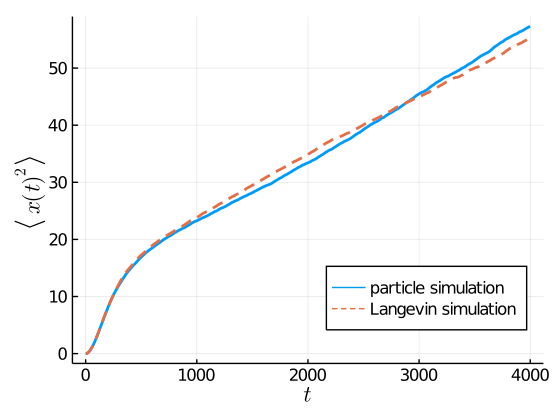

In [20]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
# title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.pdf")

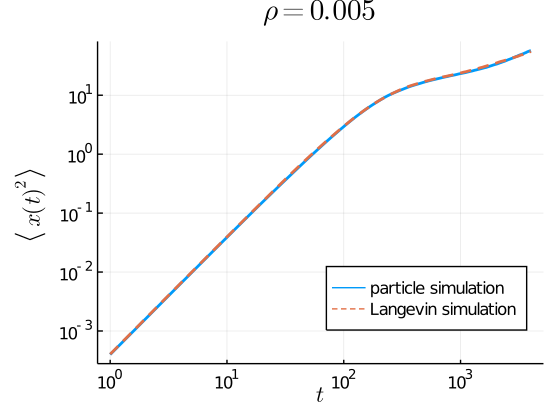

In [21]:
p2 = plot(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation", legend=:bottomright, linewidth=2,
    xaxis=:log10, yaxis=:log10,
    size=(400,300), 
    dpi=140)
plot!(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=2)
xlabel!(L"t")
ylabel!(L"\left\langle x(t)^2 \right\rangle")
title!(latexstring("\\rho="*string(growthParams["ρ"])))
display(p2)

# savefig(p2, "../Figures/growingPop_msd_logPlot_rho"*string(growthParams["ρ"])*".png")
# savefig(p2, "../Figures/growingPop_msd_logPlot_rho"*string(growthParams["ρ"])*".pdf")

In [22]:
# msdSingles_Sim = []

# for sim in 1:nSims
#     msd_t = BParts.meanSquaredDisplacement(pos_Sim[sim], msdTimes)
#     push!(msdSingles_Sim, msd_t)
# end

In [23]:
# p2 = plot(1:msdTimes[2]-msdTimes[1], msdLan_t[2:end], label="Langevin simulation", linestyle=:dash, linewidth=3,
#     legend=:topleft,
#     size=(500,300),
#     dpi=140)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart_t[2:end], label="particle simulation average", linestyle=:dashdot, linewidth=3)
# # plot!(1:msdTimes[2]-msdTimes[1], msdPart0_t[2:end])
# for s in 1:nSims
#     plot!(1:msdTimes[2]-msdTimes[1], msdSingles_Sim[s][2:end],
# #         label="particle simulation "*string(s),
#         label="")
# end
# xlabel!(L"t")
# ylabel!(L"\left\langle x(t)^2 \right\rangle")
# # title!(latexstring("\\rho="*string(growthParams["ρ"])))
# display(p2)

# # savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msd_time.png")
# savefig(p2, "../Figures/rho"*string(growthParams["ρ"])*"msdSingles_time.pdf")